# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import geopandas as gpd
import contextily as ctx
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

/var/folders/bm/87n8t34d431d_cdyv_ntp3jm0000gq/T/ipykernel_22910/962747815.py:12: DeprecationWarning: WKTReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import WKTReadingError


In [2]:
def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [3]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbp: <https://geokb.wikibase.cloud/wiki/Property:>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [4]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [5]:
pd.set_option('display.max_rows', 20)

### 0. Count total number of triples in KG

In [6]:
query = ''' SELECT (COUNT(?s) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,1253711


### 1. Deposit Types

In [7]:
query = ''' SELECT ?ci ?cn ?cg ?ce
            WHERE {
                ?ci a :DepositType .
                ?ci rdfs:label ?cn .
                ?ci :deposit_group ?cg .
                ?ci :environment ?ce .
            } '''
run_minmod_query(query, values=True)

,ci.value,cn.value,cg.value,ce.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


### 2. Mineral Inventories

#### 2.1. **Zinc** Ore values, from all inventories, their grades, & cutoff grades, for inventories with grade >= 12

In [8]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
                FILTER (?grade >= 12)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,1340000,16.8,10,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,574365,12.56,5,https://minmod.isi.edu/resource/measured
2,https://minmod.isi.edu/resource/httpsw3idorgus...,822000,18.9,10,https://minmod.isi.edu/resource/indicated
3,https://minmod.isi.edu/resource/httpsw3idorgus...,1313000,13.2,8,https://minmod.isi.edu/resource/Measured
4,https://minmod.isi.edu/resource/httpsw3idorgus...,574365,12.56,5,https://minmod.isi.edu/resource/Measured
...,...,...,...,...,...
8631,https://minmod.isi.edu/resource/httpsw3idorgus...,18300,12.98,10,https://minmod.isi.edu/resource/inferred
8632,https://minmod.isi.edu/resource/httpsw3idorgus...,18300,12.98,1.5,https://minmod.isi.edu/resource/inferred
8633,https://minmod.isi.edu/resource/httpsw3idorgus...,18300,12.98,9,https://minmod.isi.edu/resource/inferred
8634,https://minmod.isi.edu/resource/httpsw3idorgus...,18300,12.98,4,https://minmod.isi.edu/resource/inferred


#### 2.2. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [9]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,158000,1.12,0.9,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,158000,1.12,0.9,https://minmod.isi.edu/resource/inferred
2,https://minmod.isi.edu/resource/httpsw3idorgus...,158000,1.12,0.9,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/httpsw3idorgus...,158000,1.12,0.9,https://minmod.isi.edu/resource/inferred
4,https://minmod.isi.edu/resource/httpsw3idorgus...,158000,0.95,0.9,https://minmod.isi.edu/resource/inferred
...,...,...,...,...,...
1963,https://minmod.isi.edu/resource/httpsw3idorgus...,89000,0.72,0.47,https://minmod.isi.edu/resource/inferred
1964,https://minmod.isi.edu/resource/httpsw3idorgus...,89000,0.72,0.47,https://minmod.isi.edu/resource/inferred
1965,https://minmod.isi.edu/resource/httpsw3idorgus...,89000,0.72,0.47,https://minmod.isi.edu/resource/inferred
1966,https://minmod.isi.edu/resource/httpsw3idorgus...,53000,0.18,0.59,https://minmod.isi.edu/resource/inferred


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [10]:
# query = ''' SELECT ?ci ?cn ?gi
#             WHERE {
#                 ?ci a :Commodity .
#                 ?ci :name ?cn .
#                 ?ci owl:sameAs ?gi .
#             } '''
# example_df = run_minmod_query(query)
# example_df

#### 3.2. get commodity symboles from `GeoKB`

In [11]:
# def get_symbol_via_sparql(geokb_uri):
#     query = '''
#     SELECT ?symb
#     WHERE {
#         <%s> gkbt:P17 ?symb .
#     }''' % (geokb_uri)
#     result_record = run_geokb_query(query)
#     if len(result_record) > 0:
#         return result_record.iloc[0]['symb.value']
#     return ""

In [12]:
# pd.set_option('display.max_rows', 500)

# example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
# example_df

### 4. Mineral Sites

#### 4.1. all Nickel `MineralSite` instances

In [13]:
query = ''' SELECT ?ms ?msr ?mss ?loc_wkt
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
                ?ms :location_info [ :location ?loc_wkt ] .
                
                ?ms :mineral_inventory ?mi .
                ?mi :commodity [ :name "Nickel"@en ] .
            } '''
df_2 = run_minmod_query(query, values=True)
df_2

,ms.value,msr.value,mss.value,loc_wkt.value
0,https://minmod.isi.edu/resource/site__spruce-r...,Spruce Road,Mudd-and-Jowitt-2022-Nickel/AR 2018,POINT (-91.7 47.83)
1,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-Victoria (KGHM),Mudd-and-Jowitt-2022-Nickel/KGHM Presentation ...,POINT (-81.38751 46.42380)
2,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/XM7ACJDK,POINT(-93.1 46.683)
3,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/26ZXZM5R,POINT(-88.933333 48.75)
4,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury Group (Vale),Mudd-and-Jowitt-2022-Nickel/Form 20F 2018,POINT (-81.06776 46.49230)
...,...,...,...,...
96,https://minmod.isi.edu/resource/site__riddle-n...,Riddle (Nickel Mountain),Mudd-and-Jowitt-2022-Nickel/Berger et al (2011),POINT (-123.437 42.966)
97,https://minmod.isi.edu/resource/site__northmet...,NorthMet (Dunka Road),Mudd-and-Jowitt-2022-Nickel/AIF 2018,POINT (-92 47.6)
98,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-West Graham,Mudd-and-Jowitt-2022-Nickel/Tech Rep (2018-01),POINT (-81.31286 46.41797)
99,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-Podolsky (KGHM),Mudd-and-Jowitt-2022-Nickel/AIF 2010,POINT (-80.87570 46.77810)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 48486.29it/s]


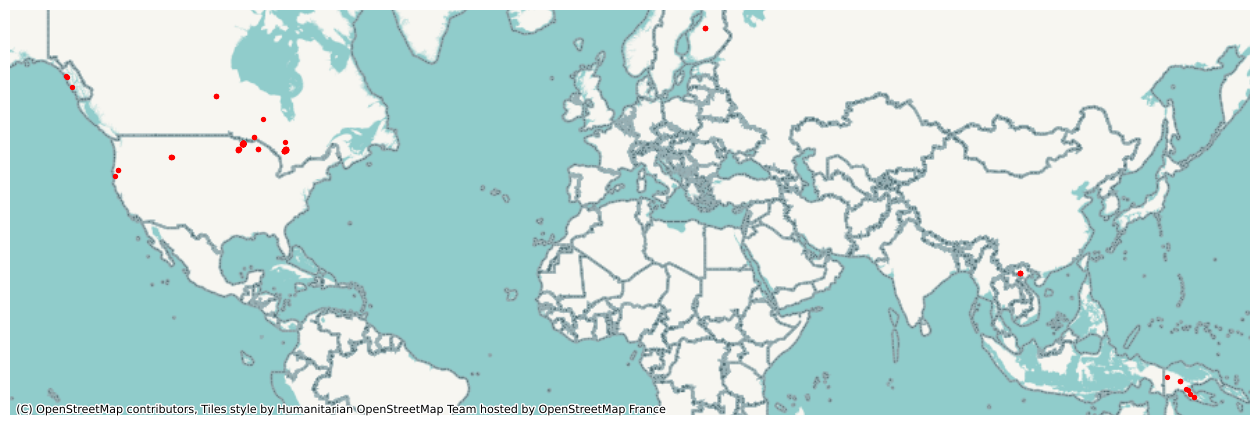

In [14]:
df_2['loc_wkt'] = df_2['loc_wkt.value'].progress_apply(safe_wkt_load)

sample_gdf = gpd.GeoDataFrame(df_2, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(16, 16))
sample_gdf.plot(ax=ax, color='red', markersize=8)
ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

### 5. Grade-Tonnage models

In [15]:
# todo: use grade-units to convert to single unit/format
# todo: use ore-units to convert to single unit/format
# todo: final resource estimate

query_template = '''
SELECT ?mineralInventory ?cont_metal ?tonnage  ?grade ?category
WHERE {
    ?mineralInventory a            :MineralInventory .
    
    ?mineralInventory :ore         ?ore .
    ?ore              :ore_value   ?tonnage .
    
    ?mineralInventory :grade       ?gradeInfo .
    ?gradeInfo        :grade_value ?grade .

    ?mineralInventory :contained_metal ?cont_metal .
    
    ?mineralInventory :commodity   ?Commodity .
    ?Commodity        :name        "%s"@en .

    ?mineralInventory :category    ?category .
}
'''

In [16]:
query_resp_df = run_minmod_query(query_template % "Zinc", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.65,Indicated
1,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.63,Indicated
2,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.65,Indicated
3,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.63,Indicated
4,httpsw3idorgusgsz453069288w9puz91-httpsw3idorg...,565500.0000,72.50,0.78,probable
...,...,...,...,...,...
1265,httpsw3idorgusgsz45306925sv8ibcw1-httpsw3idorg...,79.9558,150.86,0.53,indicated
1266,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,14788000.00,1.70,indicated
1267,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,14788000.00,1.37,indicated
1268,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,2088000.00,1.70,indicated


In [17]:
query_resp_df = run_minmod_query(query_template % "Nickel", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,158000.0,1.12,inferred
1,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,158000.0,0.95,inferred
2,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,158000.0,1.22,inferred
3,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,158000.0,5.25,inferred
4,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,2012000.0,1.12,inferred
...,...,...,...,...,...
334,httpsw3idorgusgsz45306924j6vp5m91-httpsw3idorg...,168840.0,89000.0,0.55,inferred
335,httpsw3idorgusgsz45306924j6vp5m91-httpsw3idorg...,168840.0,89000.0,0.67,inferred
336,httpsw3idorgusgsz45306924j6vp5m91-httpsw3idorg...,168840.0,89000.0,0.72,inferred
337,httpsw3idorgusgsz4530692487ftniz1-httpsw3idorg...,95400.0,53000.0,0.18,inferred


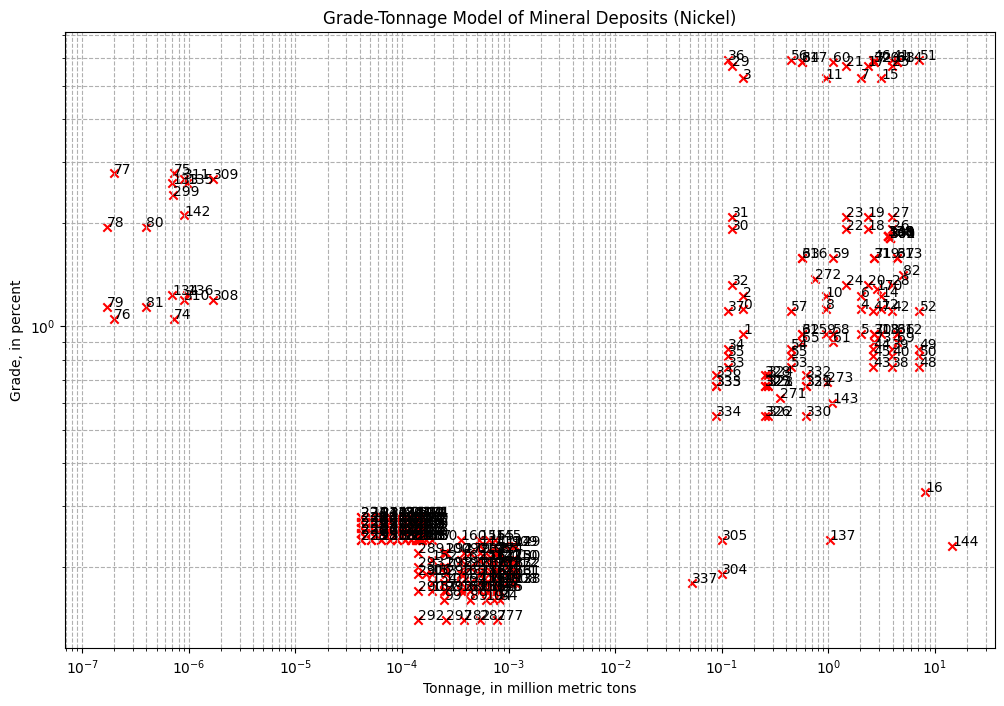

In [18]:
tonnages = mineral_data_df['tonnage'].values
grades = mineral_data_df['grade'].values
names = mineral_data_df.index.values # mineral_data_df['name'].values

# todo: convert tonnage to million metric tons using unit-transformation
tonnages_million_metric_tons = tonnages / 1e6

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tonnages_million_metric_tons, grades, marker='x', color='r')

# loga scale
plt.xscale('log')
plt.yscale('log')

# todo: units should be evaluated and converted
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages_million_metric_tons[i], grades[i]))
plt.show()

### 6. More coordinate data

In [19]:
query = '''
SELECT ?site ?loc ?tonnage ?grade
WHERE {
  ?site a :MineralSite .
  ?site :mineral_inventory ?inv .

  ?inv :commodity [ :name "Nickel"@en ] .
  ?inv :category  :Indicated .
  ?inv :ore       [ :ore_value   ?tonnage ] .
  ?inv :grade     [ :grade_value ?grade ] .
  
  ?site:location_info [ :location ?loc ] .
  FILTER(datatype(?loc) = geo:wktLiteral)
}
'''
loc_df = run_minmod_query(query, values=True)
loc_df['loc_wkt'] = loc_df['loc.value'].progress_apply(safe_wkt_load)
loc_df.dropna(inplace=True)
loc_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 27255.41it/s]


,site.value,loc.value,tonnage.value,grade.value,loc_wkt
0,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.06776 46.49230),40.8,1.27,POINT (-81.06776 46.4923)
1,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.87806 46.80500),0.264,0.65,POINT (-80.87806 46.805)
2,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.38751 46.42380),9.741,0.63,POINT (-81.38751 46.4238)
3,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.13276 46.74104),1.56,0.94,POINT (-81.13276 46.74104)
4,https://minmod.isi.edu/resource/site__ramu__mu...,POINT (145.20393 -5.57077),42.0,0.9,POINT (145.20393 -5.57077)
5,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.79985 46.58103),23.25,2.1,POINT (-80.79985 46.58103)
6,https://minmod.isi.edu/resource/site__maturi-i...,POINT (-91.8 47.8),818.3,0.18,POINT (-91.8 47.8)
7,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.89786 46.56702),0.56,1.17,POINT (-80.89786 46.56702)
8,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.87570 46.77810),6.7,0.72,POINT (-80.8757 46.7781)
9,https://minmod.isi.edu/resource/site__stillwat...,POINT (-109.9 45.39),55.4,0.1,POINT (-109.9 45.39)


## Deposit Type Classification

### Retrieve all deposit classifications

In [20]:
query = '''
SELECT ?ms ?dt_conf ?dt_s ?dt_on ?cn ?cg ?ce ?country
WHERE {
  ?ms a :MineralSite .

  ?ms :location_info [ :country ?country ] .
  
  #?ms :location_info [ :location ?loc ] .
  #FILTER(datatype(?loc) = geo:wktLiteral)
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  ?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  
  OPTIONAL { ?dpc :normalized_uri [
      rdfs:label ?cn;
      :deposit_group ?cg;
      :environment ?ce ] }
}
'''
tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,dt_on.value,country.value,cn.value,cg.value,ce.value
0,https://minmod.isi.edu/resource/site__sherlock...,5e-01,sand,Hydrothermal Ni,Australia,NaN,NaN,NaN
1,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Magmatic Sulphide,Canada,NaN,NaN,NaN
2,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Impact-related,Canada,NaN,NaN,NaN
3,https://minmod.isi.edu/resource/site__sheba-s-...,5e-01,sand,Magmatic Sulphide,South Africa,NaN,NaN,NaN
4,https://minmod.isi.edu/resource/site__sheba-s-...,5e-01,sand,Layered Intrusive,South Africa,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1709,https://minmod.isi.edu/resource/site__texmont_...,5e-01,sand,Archean Komatiite,Canada,NaN,NaN,NaN
1710,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,VMS,Russia,NaN,NaN,NaN
1711,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,Hydrothermal Ni,Russia,NaN,NaN,NaN
1712,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Magmatic Sulphide,Canada,NaN,NaN,NaN


In [21]:
nickel_dc_data_df = pd.DataFrame([
    {
        'url': row['ms.value'], # navigable
        'confidence': row['dt_conf.value'],
        'source': row['dt_s.value'],
        'observed_deposit_name': row['dt_on.value'],
        'deposit_name': row['cn.value'],
        'deposit_group': row['cg.value'],
        'deposit_environment': row['ce.value'],
        'country': row['country.value']
    }
    for index, row in tmp_df.iterrows()
])
nickel_dc_data_df

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
0,https://minmod.isi.edu/resource/site__sherlock...,5e-01,sand,Hydrothermal Ni,NaN,NaN,NaN,Australia
1,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Magmatic Sulphide,NaN,NaN,NaN,Canada
2,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Impact-related,NaN,NaN,NaN,Canada
3,https://minmod.isi.edu/resource/site__sheba-s-...,5e-01,sand,Magmatic Sulphide,NaN,NaN,NaN,South Africa
4,https://minmod.isi.edu/resource/site__sheba-s-...,5e-01,sand,Layered Intrusive,NaN,NaN,NaN,South Africa
...,...,...,...,...,...,...,...,...
1709,https://minmod.isi.edu/resource/site__texmont_...,5e-01,sand,Archean Komatiite,NaN,NaN,NaN,Canada
1710,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,VMS,NaN,NaN,NaN,Russia
1711,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,Hydrothermal Ni,NaN,NaN,NaN,Russia
1712,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Magmatic Sulphide,NaN,NaN,NaN,Canada


In [22]:
nickel_dc_data_df['source'].value_counts()

source
sand      1686
report      18
SME         10
Name: count, dtype: int64

In [23]:
nickel_dc_data_df['country'].value_counts()

country
Australia                   466
South Africa                206
Canada                      173
Russia                      122
Philippines                 107
                           ... 
Ethiopia                      2
Spain                         2
Morocco                       2
United States of America      2
Argentina                     2
Name: count, Length: 48, dtype: int64

In [24]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United")]['country'].value_counts()

country
United States               3
United States of America    2
Name: count, dtype: int64

In [25]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United States")]

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
47,https://minmod.isi.edu/resource/httpsw3idorgus...,1,SME,magmatic nickel- copper-platinum group element...,U-M layered intrusion nickel- copper-PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States of America
48,https://minmod.isi.edu/resource/httpsw3idorgus...,1,SME,magmatic nickel- copper-platinum group element...,U-M layered intrusion nickel- copper-PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States of America
199,https://minmod.isi.edu/resource/httpsw3idorgus...,1,SME,magmatic nickel-copper-PGE sulphide mineraliza...,U-M conduit nickel-copper- PGE,Ultramafic and (or) mafic conduit,Magmatic,United States
489,https://minmod.isi.edu/resource/httpsw3idorgus...,1,SME,magmatic nickel-copper-PGE sulphide mineraliza...,U-M conduit nickel-copper- PGE,Ultramafic and (or) mafic conduit,Magmatic,United States
571,https://minmod.isi.edu/resource/httpsw3idorgus...,1,SME,magmatic nickel-copper-PGE sulphide mineraliza...,U-M conduit nickel-copper- PGE,Ultramafic and (or) mafic conduit,Magmatic,United States


In [26]:
#nickel_dc_data_df.to_csv('nickel_dc_data_df.csv')

### Consolidating Desposit Type Classification dat

In [256]:
'''
Komatiite nickel-copper-PGE    Q476
U-M layered intrusion nickel- copper-PGE    Q478
U-M intrusion nickel-copper- PGE    Q481
U-M conduit nickel-copper- PGE    Q482
Ophiolite nickel-copper-PGE    Q484
Arc U-M intru- sion nickel- copper-PGE    Q486
Anorthosite conduit nickel- copper-PGE    Q488
Impact U-M intrusion nickel- copper-PGE    Q489
'''

valid_deposit_Qs = ["Q476", "Q478", "Q481", "Q482", "Q484", "Q486", "Q488", "Q489"]
valid_deposit_Qs = ['https://minmod.isi.edu/resource/' + x for x in valid_deposit_Qs]

In [257]:
query = '''
SELECT ?ms ?oms ?dt_conf ?dt_s ?cn ?cg ?ce ?country ?dtnorm ?dtnorm_label ?loc_wkt
WHERE {
  ?ms a :MineralSite .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  #?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  OPTIONAL { ?ms owl:sameAs ?oms . }
  ?dpc :normalized_uri ?dtnorm .

  ?dtnorm rdfs:label ?dtnorm_label .
      
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  OPTIONAL {
      ?ms :location_info [ :country ?country ] .
      ?ms :location_info [ :location ?loc_wkt ] .
      FILTER(datatype(?loc_wkt) = geo:wktLiteral)
  }
}'''  
# print(query)

tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,dtnorm.value,dtnorm_label.value,country.value,loc_wkt.value,oms.value
0,https://minmod.isi.edu/resource/mrds10097173,0.017464837059378624,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q302,Residual placer lead,NaN,NaN,NaN
1,https://minmod.isi.edu/resource/mrds10097173,0.04451591894030571,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q392,Orogenic silver-lead- zinc-copper- antimony,NaN,NaN,NaN
2,https://minmod.isi.edu/resource/mrds10097173,0.016356337815523148,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q428,Vein tin polymetallic,NaN,NaN,NaN
3,https://minmod.isi.edu/resource/mrds10097173,0.01856262981891632,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q326,Supergene lead,NaN,NaN,NaN
4,https://minmod.isi.edu/resource/mrds10097173,0.020068123936653137,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q430,Vein polymetallic,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
433292,https://minmod.isi.edu/resource/httpsw3idorgus...,0.08578937500715256,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q406,Magnetite- dominant IOCG,NaN,NaN,NaN
433293,https://minmod.isi.edu/resource/httpsw3idorgus...,0.05951391905546189,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q405,Hematite- dominant IOCG,NaN,NaN,NaN
433294,https://minmod.isi.edu/resource/httpsw3idorgus...,0.0502634197473526,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q449,Skarn gold ± copper ± tungsten,NaN,NaN,NaN
433295,https://minmod.isi.edu/resource/httpsw3idorgus...,0.061068423092365265,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q404,Iron oxide gold,NaN,NaN,NaN


In [259]:
# US data
filtered_us = tmp_df[tmp_df['country.value'].isin(["USA", "United States", "United States of America"])]
filtered_nickel_us = filtered_us[filtered_us['dtnorm.value'].isin(valid_deposit_Qs)]

In [ ]:
'''
# todo: this will be fixed, but for now this file can be downloaded from:
https://github.com/DARPA-CRITICALMAAS/ta2-minmod-data/tree/main/sandbox/data/
'''
df_er_results = pd.read_csv('data/grouping_result.csv')
df_er_results.dropna(inplace=True)
df_er_results = df_er_results.drop_duplicates(subset=['source', 'source_id'])
query = ''' SELECT ?ms ?ms_record_id ?ms_source_id
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?ms_record_id .
                ?ms :source_id ?ms_source_id .
            } '''
df_all_sites = run_minmod_query(query, values=True)
df_all_sites.dropna(inplace=True)
df_all_sites = df_all_sites.drop_duplicates(subset=['ms_source_id.value', 'ms_record_id.value'])

In [ ]:
merged_df = df_er_results.merge(df_all_sites, how='left',
                     left_on=['source', 'source_id'], 
                     right_on=['ms_source_id.value', 'ms_record_id.value'])

In [ ]:
hypersite_df = filtered_nickel_us.merge(merged_df, how='left',
                     left_on='ms.value', right_on='ms.value')
hypersite_df['prediction'].fillna(value=-1, inplace=True)
hypersite_df['site_hyper_id'] = hypersite_df.progress_apply(
    lambda x: 'https://minmod.isi.edu/resource/' + str(int(x.prediction)), axis=1)
hypersite_df

In [ ]:
hypersite_df['dt_conf.value'] = pd.to_numeric(hypersite_df['dt_conf.value'])
hypersite_df_filtered = hypersite_df[hypersite_df['dt_conf.value'] >= 0.025]

In [ ]:
# unique extracted sites
hypersite_df_filtered['ms.value'].nunique()

In [250]:
# unique hyper (reconciled) sites
hypersite_df_filtered['site_hyper_id'].nunique()

203

In [253]:
#save to csv
#hypersite_df_filtered.to_csv('hypersite_nickel_us_data_filtered.csv')

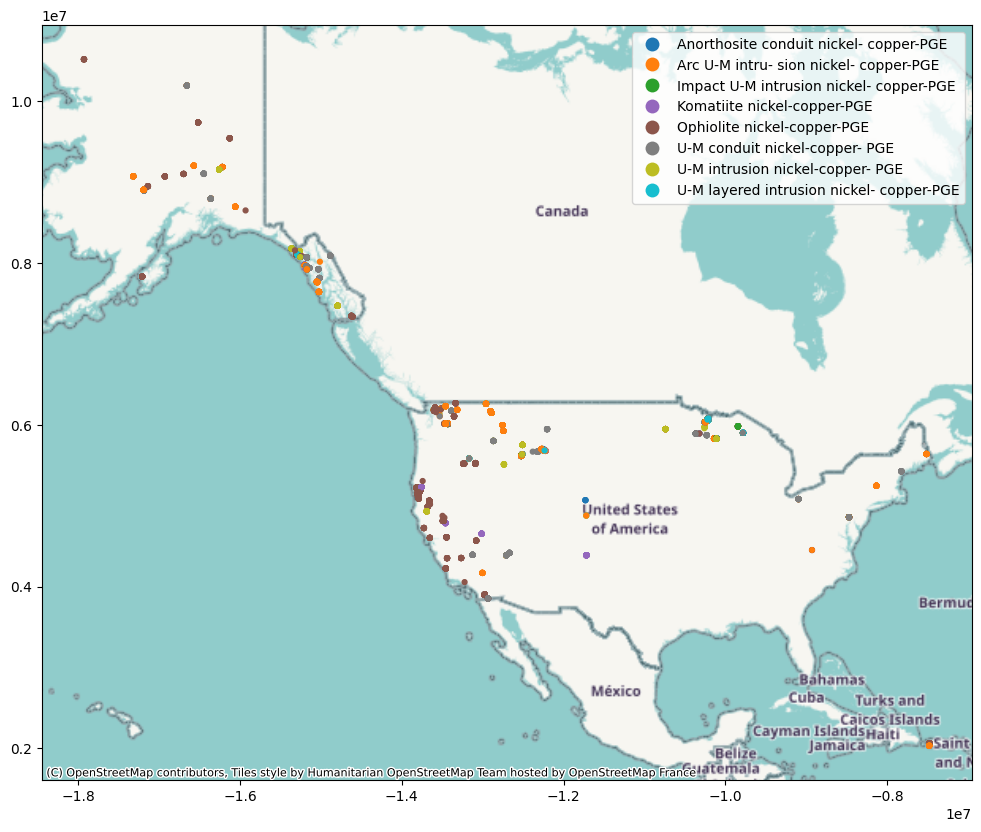

In [255]:
#visualize
hypersite_df_filtered['loc_wkt'] = hypersite_df_filtered['loc_wkt.value'].progress_apply(safe_wkt_load)
sample_gdf = gpd.GeoDataFrame(hypersite_df_filtered, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 12))
sample_gdf.plot(ax=ax, markersize=12, column='dtnorm_label.value', categorical=True, legend=True)
#ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()